In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap

In [2]:

df = pd.read_csv("../data/raw/surface_n2o_compilation.csv")
df

,cruise,date,year,month,day,latitude,longitude,depth,n2o_ppb,n2o_nM,dn2o_ppb,atmPressure,temperature,salinity
0,JOINT II Leg 0,1976-03-08,1976,3,8,22.0200,250.9200,0.0,524.622831,11.5900,224.739949,1.001743,21.900,34.664284
1,JOINT II Leg 0,1976-03-10,1976,3,10,15.6150,256.8200,0.0,365.587598,6.8200,65.701757,0.999566,27.700,33.795834
2,JOINT II Leg 0,1976-03-12,1976,3,12,9.5400,262.5600,0.0,435.085126,8.4100,135.196326,0.998316,26.400,33.940033
3,JOINT II Leg 0,1976-03-13,1976,3,13,5.1500,266.6200,0.0,462.589867,8.2900,162.699587,0.997575,29.200,32.883614
4,JOINT II Leg 0,1976-03-16,1976,3,16,-3.2200,274.7600,0.0,431.508109,8.0700,131.613389,0.997930,27.400,34.689255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158193,M100-1,2013-09-29,2013,9,29,-21.0882,12.4816,0.0,398.871600,10.5164,73.004470,1.002503,15.536,33.940000
158194,M100-1,2013-09-29,2013,9,29,-21.0902,12.4828,0.0,399.690200,10.5318,73.823095,1.002501,15.535,33.902000
158195,M100-1,2013-09-29,2013,9,29,-21.0937,12.4851,0.0,400.187600,10.5330,74.320540,1.002501,15.539,34.016000
158196,M100-1,2013-09-29,2013,9,29,-21.0955,12.4862,0.0,400.550400,10.5594,74.683363,1.002500,15.539,33.940000


In [3]:
t = pd.to_datetime(df['date'])
df['year_frac'] = t.dt.year + (t.dt.month - 1) / 12
doy = t.dt.dayofyear
df['doy_sin'] = np.sin(2 * np.pi * doy / 365)
df['doy_cos'] = np.cos(2 * np.pi * doy / 365)
for k in (2, 3):
    df[f'doy_sin_{k}'] = np.sin(2 * np.pi * k * doy / 365)
    df[f'doy_cos_{k}'] = np.cos(2 * np.pi * k * doy / 365)

In [4]:
df['cruise'].unique().size

176

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
import numpy as np
from tqdm import tqdm

FEATURES  = ["latitude", "longitude", "depth",
            "atmPressure", "temperature", "salinity", "month",
            'year_frac', 'doy_sin', 'doy_cos', 'doy_sin_2', 'doy_cos_2', 'doy_sin_3', 'doy_cos_3']
TARGET    = "dn2o_ppb"


In [6]:
X  = df[FEATURES]
y  = df[TARGET]
cruises = df["cruise"].unique()
print(f"Found {len(cruises)} unique cruises, total {len(df)} samples.")

Found 176 unique cruises, total 158198 samples.


In [7]:
cruise_sizes = df.groupby("cruise").size()
valid_cruises = cruise_sizes[cruise_sizes >= 2].index
skipped_cruises = cruise_sizes[cruise_sizes < 2].index

print(f"Uwaga: pomijam {len(skipped_cruises)} bardzo krótkich rejsów "
      f"({cruise_sizes[cruise_sizes < 2].sum()} próbek łącznie)")

Uwaga: pomijam 6 bardzo krótkich rejsów (6 próbek łącznie)


In [8]:
def make_model():
    # --- Random Forest ---
    # base = RandomForestRegressor(
    #     n_estimators = 200,
    #     random_state = 42,
    #     oob_score    = True,
    #     n_jobs       = -1,
    #     max_depth    = None,
    # )

    # --- XGBoost---
    base = XGBRegressor(
        n_estimators   = 600,
        learning_rate  = 0.05,
        max_depth      = 8,
        subsample      = 0.8,
        colsample_bytree = 0.8,
        objective      = "reg:squarederror",
        reg_lambda     = 1.0,
        n_jobs         = -1,
        random_state   = 42,
    )

    return make_pipeline(
        SimpleImputer(strategy="median"),
        base
    )

In [9]:
np.random.seed(2137)
n_test_cruises = 10

sampled_cruises = np.random.choice(
    valid_cruises,
    size=min(n_test_cruises, len(valid_cruises)),
    replace=False
)
print(f"Testuję tylko {len(sampled_cruises)} rejsów z {len(valid_cruises)} możliwych.")

Testuję tylko 10 rejsów z 170 możliwych.


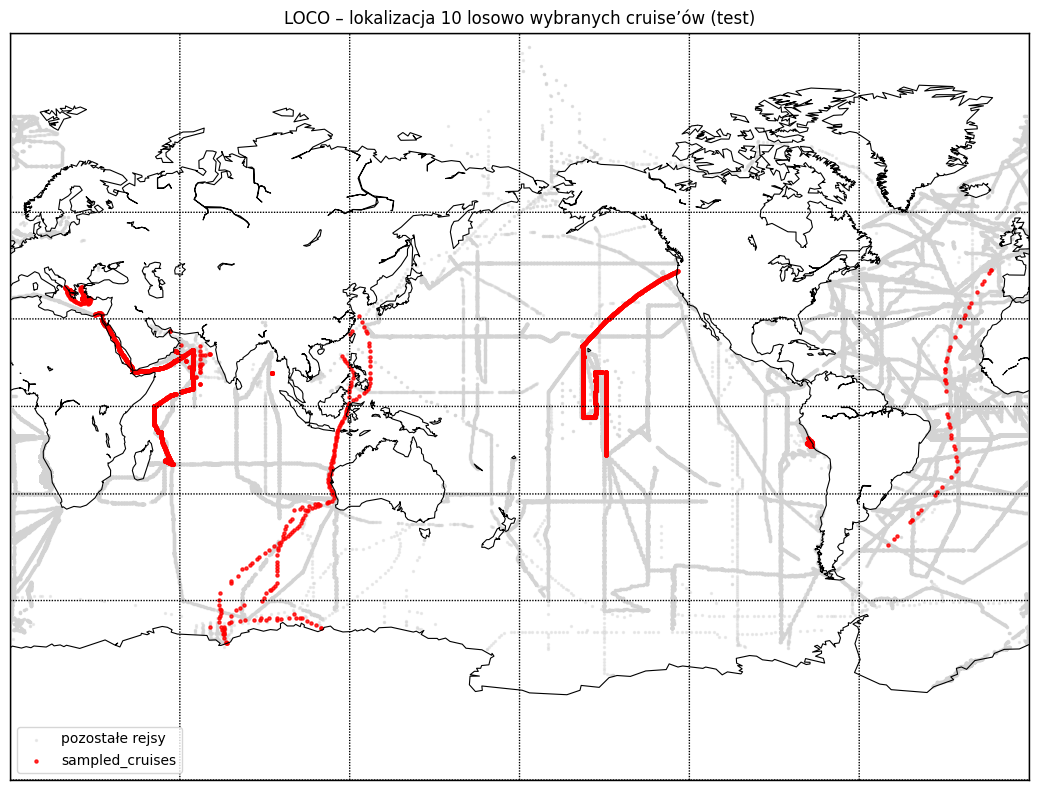

In [10]:
sel_mask   = df["cruise"].isin(sampled_cruises)
df_sel     = df[sel_mask]
df_other   = df[~sel_mask]

plt.figure(figsize=(14, 8))
m = Basemap(projection="mill", lon_0=180)
m.drawcoastlines(linewidth=0.8)
m.drawmapboundary()
m.drawparallels(range(-90, 91, 30))
m.drawmeridians(range(0, 361, 60))

x_o, y_o = m(df_other["longitude"].values, df_other["latitude"].values)
m.scatter(x_o, y_o, s=2, c="lightgrey", alpha=0.4, label="pozostałe rejsy")

x_s, y_s = m(df_sel["longitude"].values, df_sel["latitude"].values)
m.scatter(x_s, y_s, s=5, c="red", alpha=0.8, label="sampled_cruises")

plt.title(f"LOCO – lokalizacja {len(sampled_cruises)} losowo wybranych cruise’ów (test)")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

In [11]:
y_true_all, y_pred_all = [], []
cruise_metrics = []

for cruise in tqdm(sampled_cruises, desc="LOCO"):
    train_mask = df["cruise"] != cruise
    test_mask  = ~train_mask

    X_train, y_train = X[train_mask], y[train_mask]
    X_test,  y_test  = X[test_mask],  y[test_mask]

    model = make_model()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # ── store per-cruise metrics ──
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)
    cruise_metrics.append({"cruise": cruise, "rmse": rmse, "r2": r2})

    # ── accumulate for global score ──
    y_true_all.append(pd.Series(y_test.values, index=y_test.index))
    y_pred_all.append(pd.Series(y_pred,        index=y_test.index))

LOCO: 100%|██████████| 10/10 [00:19<00:00,  1.93s/it]


In [12]:
y_true_all = pd.concat(y_true_all).sort_index()
y_pred_all = pd.concat(y_pred_all).sort_index()

overall_rmse = np.sqrt(mean_squared_error(y_true_all, y_pred_all))
overall_r2   = r2_score(y_true_all, y_pred_all)

print("\n──────── LOCO summary ────────")
print(f"Overall RMSE: {overall_rmse:.4f}")
print(f"Overall R²  : {overall_r2:.4f}")


──────── LOCO summary ────────
Overall RMSE: 1471.9092
Overall R²  : -0.0785


In [13]:
df['quarter'] = t.dt.quarter

In [14]:
y_true_all, y_pred_all = [], []
q_metrics = []

for q in tqdm([1, 2, 3, 4], desc="LOQO"):
    train_mask = df['quarter'] != q
    test_mask  = ~train_mask

    X_train, y_train = df.loc[train_mask, FEATURES], df.loc[train_mask, TARGET]
    X_test,  y_test  = df.loc[test_mask,  FEATURES], df.loc[test_mask,  TARGET]

    model = make_model()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # ─ per-quarter metryki ─
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)
    q_metrics.append({"quarter": q, "n": len(y_test), "rmse": rmse, "r2": r2})

    # ─ accumulate for overall ─
    y_true_all.append(pd.Series(y_test.values, index=y_test.index))
    y_pred_all.append(pd.Series(y_pred,      index=y_test.index))

LOQO: 100%|██████████| 4/4 [00:06<00:00,  1.66s/it]


In [15]:
y_true_all = pd.concat(y_true_all).sort_index()
y_pred_all = pd.concat(y_pred_all).sort_index()

overall_rmse = np.sqrt(mean_squared_error(y_true_all, y_pred_all))
overall_r2   = r2_score(y_true_all, y_pred_all)

print("\n──────── LOQO summary ────────")
print(f"Overall RMSE: {overall_rmse:.3f}")
print(f"Overall R²  : {overall_r2:.3f}")


──────── LOQO summary ────────
Overall RMSE: 413.619
Overall R²  : -0.859


In [16]:
def random_geo_patches(df, patch_deg=10, n_patches=40, seed=42):
    rng      = np.random.RandomState(seed)
    lat_min, lat_max = df["latitude"].min(), df["latitude"].max()
    lon_min, lon_max = df["longitude"].min(), df["longitude"].max()

    lat_bins = np.arange(np.floor(lat_min/patch_deg)*patch_deg,
                        np.ceil(lat_max/patch_deg)*patch_deg + patch_deg,
                        patch_deg)
    lon_bins = np.arange(np.floor(lon_min/patch_deg)*patch_deg,
                        np.ceil(lon_max/patch_deg)*patch_deg + patch_deg,
                        patch_deg)

    grid = [(lat_bins[i], lat_bins[i]+patch_deg,
            lon_bins[j], lon_bins[j]+patch_deg)
            for i in range(len(lat_bins)-1)
            for j in range(len(lon_bins)-1)]

    rng.shuffle(grid)

    selected, mask = [], np.zeros(len(df), dtype=bool)
    for bbox in grid:
        if len(selected) >= n_patches:
            break
        la0, la1, lo0, lo1 = bbox
        inside = (df["latitude"].between(la0, la1, inclusive="left") &
                    df["longitude"].between(lo0, lo1, inclusive="left"))
        if inside.any():
            selected.append(bbox)
            mask |= inside
    return selected, mask

In [17]:
patch_list, global_test_mask  = random_geo_patches(df, patch_deg=10, n_patches=40, seed=42)
print(f"Train: {(~global_test_mask).sum():,d}  |  Test: {global_test_mask.sum():,d} "
        f"({global_test_mask.mean():.2%} of total)  in {len(patch_list)} patches")


Train: 145,292  |  Test: 12,906 (8.16% of total)  in 40 patches


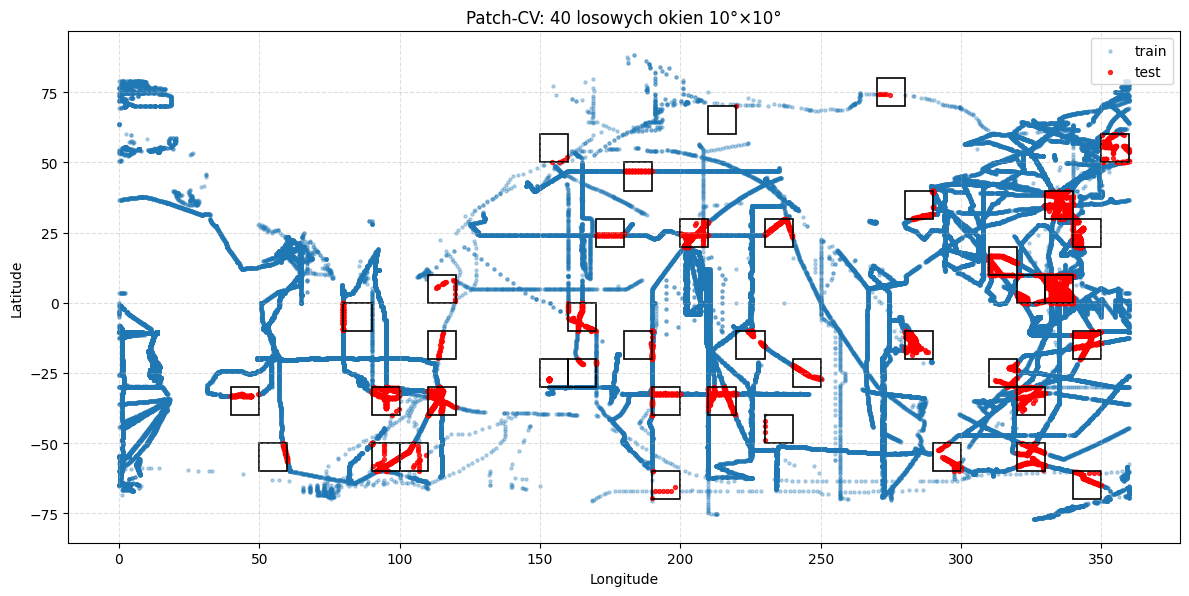

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(df.loc[~global_test_mask, "longitude"],
           df.loc[~global_test_mask, "latitude"],
           s=5, alpha=0.3, label="train")
ax.scatter(df.loc[ global_test_mask, "longitude"],
           df.loc[ global_test_mask, "latitude"],
           s=8, alpha=0.8, color="red", label="test")

for la0, la1, lo0, lo1 in patch_list:
    ax.add_patch(Rectangle((lo0, la0),
                        lo1 - lo0,
                        la1 - la0,
                        fill=False,
                        edgecolor="black",
                        linewidth=1.2))

ax.set(title="Patch-CV: 40 losowych okien 10°×10°",
        xlabel="Longitude", ylabel="Latitude")
ax.legend(loc="upper right")
ax.set_aspect("equal", adjustable="box")
ax.grid(ls="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [19]:

y_true_all, y_pred_all = [], []
patch_metrics = []

for idx, (la0, la1, lo0, lo1) in enumerate(tqdm(patch_list, desc="Patch-CV")):
    test_mask = (df["latitude"].between(la0, la1, inclusive="left") &
                    df["longitude"].between(lo0, lo1, inclusive="left"))
    train_mask = ~test_mask

    X_train, y_train = df.loc[train_mask, FEATURES], df.loc[train_mask, TARGET]
    X_test,  y_test  = df.loc[test_mask,  FEATURES], df.loc[test_mask,  TARGET]

    model = make_model()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)

    patch_metrics.append({
        "patch_id": idx,
        "lat0": la0, "lat1": la1,
        "lon0": lo0, "lon1": lo1,
        "n": len(y_test),
        "rmse": rmse, "r2": r2,
    })

    y_true_all.append(pd.Series(y_test.values, index=y_test.index))
    y_pred_all.append(pd.Series(y_pred,      index=y_test.index))

y_true_all = pd.concat(y_true_all).sort_index()
y_pred_all = pd.concat(y_pred_all).sort_index()

global_rmse = np.sqrt(mean_squared_error(y_true_all, y_pred_all))
global_r2   = r2_score(y_true_all, y_pred_all)

Patch-CV:  25%|██▌       | 10/40 [00:19<00:57,  1.91s/it]d:\Coding\Venvs\DataScience\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
Patch-CV: 100%|██████████| 40/40 [01:11<00:00,  1.79s/it]


In [20]:
print(f"\n==== Patch-CV summary ====")
print(f"Global RMSE: {global_rmse:.3f}")
print(f"Global R²  : {global_r2:.3f}")


==== Patch-CV summary ====
Global RMSE: 901.562
Global R²  : 0.092
